# Setting up and running a relative binding free energy network using alchemiscale


This notebook details the process of running a relative binding free energy calculation using the [openfe](https://github.com/OpenFreeEnergy/openfe/) toolkit and the execution platform [alchemiscale](https://github.com/openforcefield/alchemiscale).

The notebook is broken down into the following section:
  1. Creating and visualizing a ligand network from input files
  2. Creating an alchemical network
  3. Submitting an alchemical network to `alchemiscale`
  4. Monitoring the progress of an `alchemiscale` submission
  5. Gathering results and analyzing them using

## Creating and visualizing a ligand network

In this section, we take a pre-prepared input set of ligands (in the SDF file `ligands.sdf`) and create a network of transformations between each ligand in the set. This network is then used in later parts of this notebook to define the alchemical calculations which we will submit to `alchemiscale`.

**Note: all inputs are taken from the TYK2 dataset as provided in the [protein-ligand-benchmark set](https://github.com/openforcefield/protein-ligand-benchmark)**

In [1]:
# First we start with some base imports
import openfe
import gufe
from rdkit import Chem

/home/ialibay/software/mambaforge/install/envs/alchemiscale-client/lib/python3.10/site-packages/perses/rjmc/coordinate_numba.py:14: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  n_2 = np.dot(a, a)
/home/ialibay/software/mambaforge/install/envs/alchemiscale-client/lib/python3.10/site-packages/perses/rjmc/coordinate_numba.py:65: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  d_ang = np.dot(angle_rotation_matrix, d_r)
/home/ialibay/software/mambaforge/install/envs/alchemiscale-client/lib/python3.10/site-packages/perses/rjmc/coordinate_numba.py:137: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  if np.dot(a, plane2) <= 0:


### Loading the ligands

We first start by loading the ligands into RDKit molecules, and then convert them to `gufe.SmallMoleculeComponents`. `SmallMoleculeComponents` are effectively thin wrapper arounds RDKit molecules and offer a stable translation layer between RDKit and OpenFF molecules.

**Note: `SmallMoleculeComponents` can be created from OpenFF molecules directly. This can be useful when trying to pass certain pre-calculated properties such as partial charges.**

In [3]:
# We load RDKit molecules from the `ligands.sdf` file. Note that we need all
# atoms present so we make sure that removeHs is set to False.
rdmols = [mol for mol in Chem.SDMolSupplier("ligands.sdf", removeHs=False)]

# The OpenFE RBFE protocol does not yet support charge changes (to be changed very soon!)
# Here we raise an error if a change in formal charge is identified
base_formalcharge = Chem.rdmolops.GetFormalCharge(rdmols[0])

for mol in rdmols[1:]:
    if Chem.rdmolops.GetFormalCharge(mol) != base_formalcharge:
        errmsg = f"The molecule {mol} has a different formal charge than the first ligand molecule"
        raise ValueError(errmsg)

In [4]:
# Once validated, we convert all our RDKit molecules to SmallMoleculeComponents
ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in rdmols]

### Creating an alchemical network

Once a series of ligands has been defined, we can move on to creating a `LigandNetwork`. A `LigandNetwork` defined a series of potential alchemical transformations between a set of ligands. The network has small molecules as nodes and atom mappings, the description of the alchemically mutatation between the molecules, as its edges.

The pipeline for creating a `LigandNetwork` involves three components:
    - `AtomMapper`: This proposes potential atom mappings for pairs of ligands. Here we will use the `LomapAtomMapper` which uses [LOMAP](https://github.com/OpenFreeEnergy/Lomap) to define mappings.
    - `Scorer`: Given an atom mapping, this provides an estimate of the quality of that mapping (lower scores are better). Here we use the `default_lomap_scorer` from LOMAP.
    - `Network Planner`: This creates the `LigandNetwork`. OpenFE implements various different ways of creating a `LigandNetwork`, including hand defined, radial, and minimum spanning networks. Here we will demonstrate how to create a minimum spanning network with the `generate_minimal_spanning_network` method.
    
**Note: if you are running protein-ligand benchmark calculations, there are networks already defined in the repository. As relative free energies are sensitive to both the chosen network and the mapping used, you should aim to use those to ensure reproducibility.**

In [5]:
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=True)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

In [6]:
# Note creating a minimum spanning tree requires an all-to-all mapping generation
# This can be quite time consuming...
ligand_network = network_planner(
    ligands=ligands,
    mappers=[mapper],
    scorer=scorer
)

 38%|###8      | 30/78 [00:01<00:02, 19.49it/s]

Now we can look at the overall structure of the `LigandNetwork`.

**Note: unless you are using the right matplotlib backend this will probably be quasi-impossible to look at**

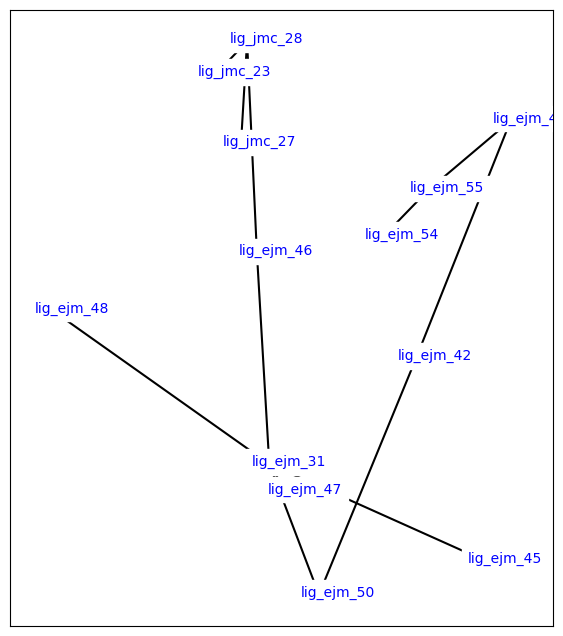

In [8]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

More importantly we can inspect individual mappings and ensure that the atom correspondances have been properly set.

In [11]:
from openfe.utils.visualization_3D import view_mapping_3d
from ipywidgets import interact, widgets

# Create method to display edges
edges = list(ligand_network.edges)

def display_edge_3d(index):
    view = view_mapping_3d(edges[index], spheres=True, show_atomIDs=True)
    view.show()

In [12]:
# traverse through all views
interact(display_edge_3d, index=widgets.IntSlider(min=0, max=len(edges)-1, step=1));

interactive(children=(IntSlider(value=0, description='index', max=11), Output()), _dom_classes=('widget-intera…

We can also look at the mappings in 2D

In [16]:
def display_edge_2d(index):
    edges[index]._ipython_display_()

In [17]:
interact(display_edge_2d, index=widgets.IntSlider(min=0, max=len(edges)-1, step=1));

interactive(children=(IntSlider(value=0, description='index', max=11), Output()), _dom_classes=('widget-intera…

Finally we serialize the network as a graphml file for future use.

In [18]:
with open("ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

## Creating an alchemical network

### Creating the remaining `Components` of our `ChemicalSystem`s

Once we have defined the network of ligand transformations we want to investigate, we next look to define the other components of our system. For the TYK2 system this involves a protein target (for the complex simulations, defined under `protein.pdb`) and solvent (i.e. how the system will be solvated).

These `Components` will be combined together at a later point in order to create the `ChemicalSystems` that define the nodes of our `AlchemicalNetwork`.

In [21]:
# First we define a SolventComponent which defines how the complex and solvent legs
# of the simulation will be solvated.
# By default we solvate using a water box with NaCl at 0.15 M
solvent = openfe.SolventComponent()

In [22]:
# Next we create a ProteinComponent which contains our target protein
protein = openfe.ProteinComponent.from_pdb_file("protein.pdb")

### Creating a simulation `Protocol`

The actual simulation is performed by a `Protocol`. Here we use an OpenMM-based hybrid topology relative free energy `Protocol`.

By default this is a replica exchange simulation using 11 replicas each occupying an equidistant lambda window across alchemical space. To ensure compatibility with `alchemiscale`, we set alter some of our default settings below.

In [24]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
from openff.units import unit

default_settings = RelativeHybridTopologyProtocol.default_settings()
# Here we make it so that each simulation only encompasses a single repeat
# We then do multiple repeats by running each simulation multiple time
default_settings.alchemical_sampler_settings.n_repeats = 1
# We enforce the compute platform to be CUDA. This ensures that a bad GPU node
# on alchemiscale will fail automatically rather than trying to defaul to the CPU kernels
default_settings.engine_settings.compute_platform = "CUDA"
# We set the protocol to auto terminate once the error drops below 0.2 kT
default_settings.alchemical_sampler_settings.online_analysis_target_error = 0.2 * unit.boltzmann_constant * unit.kelvin

# We create a standard protocol based on these default settings
protocol = RelativeHybridTopologyProtocol(default_settings)

### Combining everything into an `AlchemicalNetwork`

The `AlchemicalNetwork` contains all the information needed to run the entire campaign. It consists of a `Transformation` for each leg of the campaign. We'll loop over all the mappings, and then loop over the legs. In that inner loop, we'll make each transformation.

In [25]:
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and ligand components
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}
        
        # if our transformation involves a complex, we add in the ProteinComponent
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein
        
        # We create a ChemicalSystem for each end state of the transformation
        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")
        
        # Combine everything into a Transformation object
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=protocol,  # use protocol created above
            name=f"{sysA.name}_{sysB.name}_{leg}"
        )
        transformations.append(transformation)

# We then feed in all the Transformations to create an AlchemicalNetwork
network = openfe.AlchemicalNetwork(transformations)

## Submitting the `AlchemicalNetwork` to `Alchemiscale`

Once the `AlchemicalNetwork` has been defined, we can then go ahead and submit it to `Alchemiscale` for execution.

### Setting the `Alchemiscale` client

First we load up our credentials and create an alchemiscale client.

**Important: make sure to keep your credentials private. Here we use os.environ to fetch them from locally stored environment variables.**

In [2]:
# Get alchemiscale client from env var defined ID and KEY
import os
from alchemiscale import AlchemiscaleClient, Scope, ScopedKey
user_id = os.environ['ALCHEMISCALE_ID']
user_key = os.environ['ALCHEMISCALE_KEY']
asc =  AlchemiscaleClient('https://api.alchemiscale.org', user_id, user_key)

### Defining a scope and uploading our alchemical network

We upload our network by defining the scope within which it will exist and calling `create_network` with both this scope and the previously created `AlchemicalNetwork`.

In [22]:
# Get scope and create network
scope = Scope('openfe', 'v0_11_0', 'tyk2_perses')
network_sk = asc.create_network(network, scope)
print(network_sk)

Output()

AlchemicalNetwork-89ab68453558c8c1ff0df2b076be3d2b-openfe-v0_11_0-tyk2_perses


For future use, we also store the `scoped key`. This will make it easier to retreive our submitted network post submission.

In [23]:
# store the scoped key
with open('scoped-key.dat', 'w') as f:
    f.write(str(network_sk))

### Executing tasks

If we query the status of the network we can see that no simulation tasks have been submitted. We next need to tell `Alchemiscale` which transformations to run.

In [24]:
asc.get_network_status(network_sk)

AlchemicalNetwork-89ab68453558c8c1ff0df2b076be3d2b-openfe-v0_11_0-tyk2_perses                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                            0 │
│ running                                                          │                                            0 │
│ waiting                                                          │                                            0 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{}

To do this, we loop over our the edges of our network (i.e. the individual `Transformations`) and create an `Alchemiscale` task for each of them.

Here we set `count` to `3` in order to run three replicate simulations. This will allow us to get a minimum estimate of the sampling error in our transformation.

In [ ]:
# action out tasks
for transform in network.edges:
    transform_sk = asc.get_scoped_key(transform, scope)
    tasks = asc.create_tasks(transform_sk, count=3)
    asc.action_tasks(tasks, network_sk)

Once all the `tasks` have been submitted, we can inspect the status of the network. We now see that they have been set to `waiting`.

In [26]:
asc.get_network_status(network_sk)

AlchemicalNetwork-89ab68453558c8c1ff0df2b076be3d2b-openfe-v0_11_0-tyk2_perses                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                            0 │
│ running                                                          │                                            0 │
│ waiting                                                          │                                           72 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'waiting': 72}

## Monitoring the progress of an `alchemiscale` submission

Once submitted, we can monitor the current status of an `Alchemiscale` submission.

To avoid having to re-create the network, we read in the scoped key we earlier wrote to file.

In [3]:
with open('scoped-key.dat', 'r') as f:
    network_sk = f.read()

asc.get_network_status(network_sk)

AlchemicalNetwork-89ab68453558c8c1ff0df2b076be3d2b-openfe-v0_11_0-tyk2_perses                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                           72 │
│ running                                                          │                                            0 │
│ waiting                                                          │                                            0 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'complete': 72}

### Inspecting errors

As we can see above, some of the tasks seemed to have gone to `error` status. Due to the heterogenous nature of the compute services and the often unstable nature of these simulations, we often expect a couple of failed simulations per network.

We can inspect these errors in the following manner:

In [29]:
from pprint import pprint

err_tasks = asc.get_network_tasks(network_sk, status="error")
failures = [asc.get_task_failures(task) for task in err_tasks]

for failure in failures:
    pprint(failure[0].protocol_unit_failures[0].traceback)

Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-cf44fbbb2b79253388a20e7d1083fcf2-openfe-v0_11_0-tyk2_perses/failures/ProtocolDAGResult-4c3703a3b1db6234075854274975b3b5-openfe-v0_11_0-tyk2_perses "HTTP/1.1 200 OK"


/home/ialibay/software/mambaforge/install/envs/alchemiscale-client/lib/python3.10/site-packages/alchemiscale/interface/client.py:881: RuntimeWarning: coroutine 'use_session.<locals>._wrapper' was never awaited
  return asyncio.run(async_request(self))


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-cf44fbbb2b79253388a20e7d1083fcf2-openfe-v0_11_0-tyk2_perses/failures/ProtocolDAGResult-ebf70a0e151a656f9fbd19663ea5cdd7-openfe-v0_11_0-tyk2_perses "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-20e31a4c05435f39fb0201de8e9d2012-openfe-v0_11_0-tyk2_perses/failures/ProtocolDAGResult-30c682fa62c74bf297cb9234155b87e8-openfe-v0_11_0-tyk2_perses "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-9e3db179d1ebb3beecdd96b5b78647c6-openfe-v0_11_0-tyk2_perses/failures/ProtocolDAGResult-2b898154a2647096fd2600a3c7889802-openfe-v0_11_0-tyk2_perses "HTTP/1.1 200 OK"


('Traceback (most recent call last):\n'
 '  File '
 '"/opt/conda/lib/python3.10/site-packages/openmmtools/multistate/multistatesampler.py", '
 'line 1328, in _propagate_replica\n'
 '    mcmc_move.apply(thermodynamic_state, sampler_state, '
 'context_cache=self.sampler_context_cache)\n'
 '  File "/opt/conda/lib/python3.10/site-packages/openmmtools/mcmc.py", line '
 '1151, in apply\n'
 '    super(LangevinDynamicsMove, self).apply(thermodynamic_state, '
 'sampler_state,\n'
 '  File "/opt/conda/lib/python3.10/site-packages/openmmtools/mcmc.py", line '
 '755, in apply\n'
 '    raise IntegratorMoveError(err_msg, self, context)\n'
 'openmmtools.mcmc.IntegratorMoveError: Potential energy is NaN after 20 '
 'attempts of integration with move LangevinDynamicsMove\n'
 '\n'
 'During handling of the above exception, another exception occurred:\n'
 '\n'
 'Traceback (most recent call last):\n'
 '  File '
 '"/opt/conda/lib/python3.10/site-packages/gufe/protocols/protocolunit.py", '
 'line 319, in exec

### Restarting errors

From the tracebacks we can see that we encountered a couple of `SimulationNaNError`s. This is quite common and tends to happen at random. We can restart the simulations and these _should_ complete.

In [30]:
err_tasks = asc.get_network_tasks(network_sk, status="error")
asc.set_tasks_status(err_tasks, 'waiting')
asc.get_network_status(network_sk)

INFO:	HTTP Request: POST https://api.alchemiscale.org/bulk/tasks/status/set "HTTP/1.1 200 OK"


AlchemicalNetwork-89ab68453558c8c1ff0df2b076be3d2b-openfe-v0_11_0-tyk2_perses                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                           68 │
│ running                                                          │                                            0 │
│ waiting                                                          │                                            4 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'complete': 68, 'waiting': 4}

## Gathering results and analyzing them

Once our simulations have all completed we can go ahead and gather our free energy calculation results.

In [4]:
# If necessary we can re-define our scope and network from what we wrote to file
scope = Scope('openfe', 'v0_11_0', 'tyk2_perses')
network = asc.get_network(network_sk)

Output()

In [5]:
# Next we define a convenience method to check what type of transformation we are looking at
def _scan_components(system):
    comps = system.components.values()
    if any([isinstance(comp, openfe.ProteinComponent) for comp in comps]):
        return "complex"
    elif any([isinstance(comp, openfe.SolventComponent) for comp in comps]):
        return "solvent"
    else:
        return "vacuum"

In [8]:
# Next we create a results dictionary and scan our network edges to accumulate all
# the free energy results and their uncertainty
results = dict()
for transformation in network.edges:
    sk = asc.get_scoped_key(transformation, scope)
    result = asc.get_transformation_results(sk)
    runtype = _scan_components(transformation.stateA)
    mapping = transformation.mapping['ligand']
    nameA = mapping.componentA.name
    nameB = mapping.componentB.name

    # store in accumulator
    if f"{nameA}_{nameB}" in results.keys():
        results[f"{nameA}_{nameB}"][runtype] = result
    else:
        results[f"{nameA}_{nameB}"] = {runtype: result, 'molA': nameA, 'molB': nameB}

    # output individual results to a separate `.dat` file for future use
    filename = f"{nameA}_{nameB}.{runtype}.results.dat"
    output = f"{result.get_estimate()},{result.get_uncertainty()}"

    with open(filename, 'w') as f:
        f.write(output)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

### Writing out a `cinnabar` input CSV file

Since this is a known benchmark system, we have experimental values for each of our ligands. We can combine them with our results to create a `cinnabar` input CSV file.

**Note: this will change very soon. We are in the process of refactoring the cinnabar API.**

In [12]:
# Here we create a dictionary of experimental values from an input protein-ligand benchmark ligands.yml

# First load the yaml data
import yaml

with open('ligands.yml') as stream:
    exp_data = yaml.safe_load(stream)

In [13]:
# Define a method for converting between Ki to estimated DG
from openff.units import unit
import math

def ki_to_dg(
    ki: unit.Quantity, uncertainty: unit.Quantity,
    temperature: unit.Quantity = 298.15 * unit.kelvin
) -> tuple[unit.Quantity, unit.Quantity]:
    """
    Convenience method to convert a Ki w/ a given uncertainty to an
    experimental estimate of the binding free energy.
    
    Parameters
    ----------
    ki : unit.Quantity
        Experimental Ki value (e.g. 5 * unit.nanomolar)
    uncertainty : unit.Quantity
        Experimental error. Note: returns 0 if =< 0 * unit.nanomolar.
    temperature : unit.Quantity
        Experimental temperature. Default: 298.15 * unit.kelvin.
        
    Returns
    -------
    DG : unit.Quantity
        Gibbs binding free energy.
    dDG : unit.Quantity
        Error in binding free energy.
    """
    if ki > 1e-15 * unit.nanomolar:
        DG = (unit.molar_gas_constant * temperature.to(unit.kelvin)
              * math.log(ki / unit.molar)).to(unit.kilocalorie_per_mole)
    else:
        raise ValueError("negative Ki values are not supported")
    if uncertainty > 0 * unit.molar:
        dDG = (unit.molar_gas_constant * temperature.to(unit.kelvin)
               * uncertainty / ki).to(unit.kilocalorie_per_mole)
    else:
        dDG = 0 * unit.kilocalorie_per_mole
        
    return DG, dDG

In [14]:
from openff.units import unit

exp_values = {}
for lig in exp_data:
    exp_units = unit(exp_data[lig]['measurement']['unit'])
    exp_values[lig] = {}
    DG, dDG = ki_to_dg(exp_data[lig]['measurement']['value'] * exp_units,
                       exp_data[lig]['measurement']['error'] * exp_units)
    exp_values[lig]['value'] = DG
    exp_values[lig]['error'] = dDG

In [18]:
import numpy as np

# write out the cinnabar input file
with open('cinnabar_input.csv', 'w') as f:
    f.write("# Experimental block\n")
    f.write("# Ligand, expt_DDG, expt_dDDG\n")
    for entry in exp_values:
        f.write(f"{entry},{exp_values[entry]['value'].m:.2f},{exp_values[entry]['error'].m:.2f}\n")
    f.write('\n')
    
    f.write('# Calculated block\n')
    f.write('# Ligand1,Ligand2,calc_DDG,calc_dDDG(MBAR),calc_dDDG(additional)\n')
    for entry in results:
        estimate = (results[entry]['complex'].get_estimate()
                    - results[entry]['solvent'].get_estimate())
        err = np.sqrt(results[entry]['complex'].get_uncertainty()**2
                      + results[entry]['solvent'].get_uncertainty()**2)
        molA = results[entry]['molA']
        molB = results[entry]['molB']
        f.write(f"{molA},{molB},{estimate.m:.2f},0,{err.m:.2f}\n")

### Plotting out results using `cinnabar` components

**Note: this is a non-standard use of `cinnabar`. The ability to use the API to directly return a plotting object will be fixed in the next release.**

In [4]:
import numpy as np
import matplotlib.pylab as plt
from cinnabar import plotting, wrangle, stats
%matplotlib inline

In [7]:
def feplot(csv, name):
    fe = wrangle.FEMap(csv)
    fe.generate_absolute_values()
    
    # data
    x_dG = np.asarray([node[1]["exp_DG"] for node in fe.graph.nodes(data=True)])
    y_dG = np.asarray([node[1]["calc_DG"] for node in fe.graph.nodes(data=True)])
    y_dG = y_dG - np.mean(y_dG) + np.mean(x_dG)
    xerr_dG = np.asarray([node[1]["exp_dDG"] for node in fe.graph.nodes(data=True)])
    yerr_dG = np.asarray([node[1]["calc_dDG"] for node in fe.graph.nodes(data=True)])
    x_ddG = np.asarray([x[2]["exp_DDG"] for x in fe.graph.edges(data=True)])
    y_ddG = np.asarray([x[2]["calc_DDG"] for x in fe.graph.edges(data=True)])
    xerr_ddG = np.asarray([x[2]["exp_dDDG"] for x in fe.graph.edges(data=True)])
    yerr_ddG = np.asarray([x[2]["calc_dDDG"] for x in fe.graph.edges(data=True)])

    # RBFE
    statistics = ["RMSE", "MUE"]
    stats_rbfe = {}
        
    for statistic in statistics:
        s = stats.bootstrap_statistic(x_ddG, y_ddG, xerr_ddG, yerr_ddG, statistic=statistic)
        stats_rbfe[statistic] = s

    textstr = '\t'.join((
        f"$RMSE$ = {stats_rbfe['RMSE']['mle']:.2f} [95%: {stats_rbfe['RMSE']['low']:.2f}, {stats_rbfe['RMSE']['high']:.2f}]",
        f"$MUE$ = {stats_rbfe['MUE']['mle']:.2f} [95%: {stats_rbfe['MUE']['low']:.2f}, {stats_rbfe['MUE']['high']:.2f}]"
    ))        
        
    color = np.abs(x_ddG - y_ddG)
    cm = plt.get_cmap('coolwarm')
    color = cm(color / 2.372)
    fig, ax = plt.subplots()
    ax.errorbar(x_ddG, y_ddG, xerr=xerr_ddG, yerr=yerr_ddG, color='black', linewidth=0.0, elinewidth=2.0, zorder=1)
    ax.scatter(x_ddG, y_ddG, color=color, s=50, marker='o', zorder=2)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    ax.set_title(f'{name}\n', fontsize=24, pad=25)
    ax.set_xlabel(r'Experimental $\/\Delta \Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_ylabel(r'Calculated $\/\Delta \Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_xticks(np.arange(-4, 6,step=2.0))
    ax.set_yticks(np.arange(-4, 6,step=2.0))
    x = np.linspace(-4, 4, 100)
    ax.plot(x, x, linestyle='--', color='black', alpha=0.5)
    ax.fill_between(x, x+1, x-1, color='grey', alpha=0.2)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig.suptitle(textstr, fontsize=12)
    fig.savefig(f'{name}-RBFEs.png', dpi=600, bbox_inches="tight")
        
    # ABFE
    statistics=["RMSE", "MUE", "R2", "rho"]
        
    stats_abfe = {}
        
    for statistic in statistics:
        s = stats.bootstrap_statistic(x_dG, y_dG, xerr_dG, yerr_dG, statistic=statistic)
        stats_abfe[statistic] = s
    err_str = '\t'.join((
        f"$RMSE$ = {stats_abfe['RMSE']['mle']:.2f} [95%: {stats_abfe['RMSE']['low']:.2f}, {stats_abfe['RMSE']['high']:.2f}]",
        f"$MUE$ = {stats_abfe['MUE']['mle']:.2f} [95%: {stats_abfe['MUE']['low']:.2f}, {stats_abfe['MUE']['high']:.2f}]"
    ))
    corr_str = '\t'.join((
        f"$r$ = {stats_abfe['rho']['mle']:.2f} [95%: {stats_abfe['rho']['low']:.2f}, {stats_abfe['rho']['high']:.2f}]",
        f"$R^2$ = {stats_abfe['R2']['mle']:.2f} [95%: {stats_abfe['R2']['low']:.2f}, {stats_abfe['R2']['high']:.2f}]"
    ))
    textstr = '\n'.join((
        err_str,
        corr_str,
    ))
        
    color = np.abs(x_dG - y_dG)
    color = cm(color / 2.372)
    fig, ax = plt.subplots()
    ax.errorbar(x_dG, y_dG, xerr=xerr_dG, yerr=yerr_dG, color='black', linewidth=0.0, elinewidth=2.0, zorder=1)
    ax.scatter(x_dG, y_dG, color=color, s=50, marker='o', zorder=2)
    ax.set_xlim(-14, -6)
    ax.set_ylim(-14, -6)

    ax.set_title(f'{name}\n', fontsize=24, pad=25)
    ax.set_xlabel(r'Experimental $\/\Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_ylabel(r'Calculated $\/\Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_xticks(np.arange(-14, -4,step=2.0))
    ax.set_yticks(np.arange(-14, -4,step=2.0))
    x = np.linspace(-14, -6, 100)
    ax.plot(x, x, linestyle='--', color='black', alpha=0.5)
    ax.fill_between(x, x+1, x-1, color='grey', alpha=0.2)
        
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig.suptitle(textstr, fontsize=12)
    fig.savefig(f'{name}-ABFEs.png', dpi=600, bbox_inches="tight")

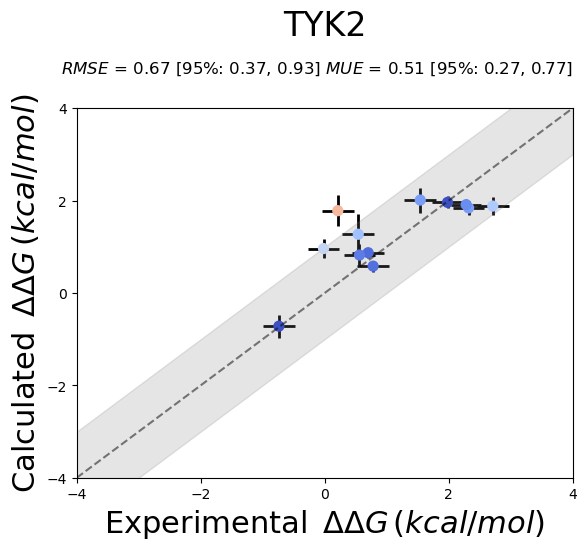

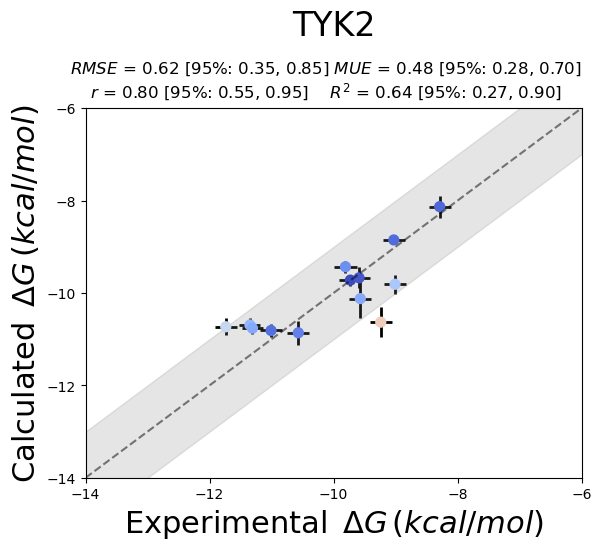

In [8]:
feplot('cinnabar_input.csv', 'TYK2')